In [1]:
try:
    import torch
except:
    print("PyTorch not found. Please install it.")

In [2]:
from datetime import datetime
from ecallisto_ng.plotting.plotting import plot_spectogram_mpl, plot_spectogram
from ecallisto_ng.combine_antennas.combine import (
    preprocess_data,
    sync_spectrograms,
    match_spectrograms,
)
from ecallisto_ng.combine_antennas.utils import round_frequencies_to_nearest_bin
import pandas as pd
import numpy as np
from datetime import datetime
from ecallisto_ng.data_download.downloader import (
    get_ecallisto_data,
)

In [4]:
start_datetime = datetime(2021, 5, 7, 3, 39, 0)
end_datetime = datetime(2021, 5, 7, 3, 42, 0)

In [5]:
substrings_to_get = ['Australia-ASSA_01', 'Australia-ASSA_02']#'ALMATY_58']

In [6]:
# Download all available data
datas = []
for substring in substrings_to_get:
    dfs = get_ecallisto_data(start_datetime, end_datetime, substring, freq_start=23)
    if isinstance(dfs, dict):
        datas.extend(dfs.values())
    else:
        datas.append(dfs)

In [7]:
datas[0].attrs

{'DATAMAX': 254,
 'DATE': '2021-05-07',
 'EXTEND': True,
 'PWM_VAL': 120,
 'TELESCOP': 'Radio Spectrometer',
 'OBJECT': 'Sun',
 'CTYPE2': 'Frequency [MHz]',
 'FRQFILE': 'FRQ15087.CFG',
 'NAXIS2': 200,
 'CRPIX1': 0,
 'SIMPLE': True,
 'ORIGIN': 'Sunnydale_SA',
 'DATE-END': '2021-05-07',
 'OBS_LAT': 34.6699981689453,
 'CRVAL2': 200.0,
 'BSCALE': 1.0,
 'COMMENT': '  FITS Definition document #100 and other FITS information.',
 'NAXIS': 2,
 'NAXIS1': 720,
 'OBS_ALT': 50.0,
 'CTYPE1': 'Time [UT]',
 'CONTENT': '2021/05/07  Radio flux density, e-CALLISTO (Australia-ASSA)',
 'OBS_LON': 139.639999389648,
 'DATE-OBS': '2021-05-07',
 'BZERO': 0.0,
 'OBS_LOC': 'E',
 'CDELT1': 0.25,
 'BITPIX': 8,
 'DATAMIN': 0,
 'CRPIX2': 0,
 'CDELT2': -1.0,
 'INSTRUME': 'Australia-ASSA',
 'OBS_LAC': 'S',
 'BUNIT': 'digits',
 'ANTENNAID': '01',
 'TIME-OBS': '03:39:00',
 'TIME-END': '03:41:59',
 'FULLNAME': 'Australia-ASSA_01'}

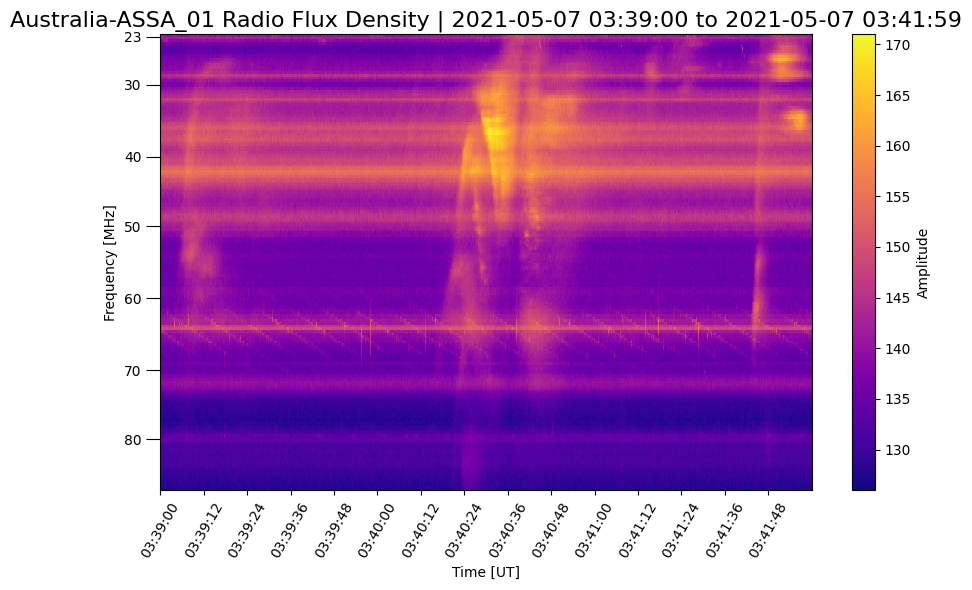

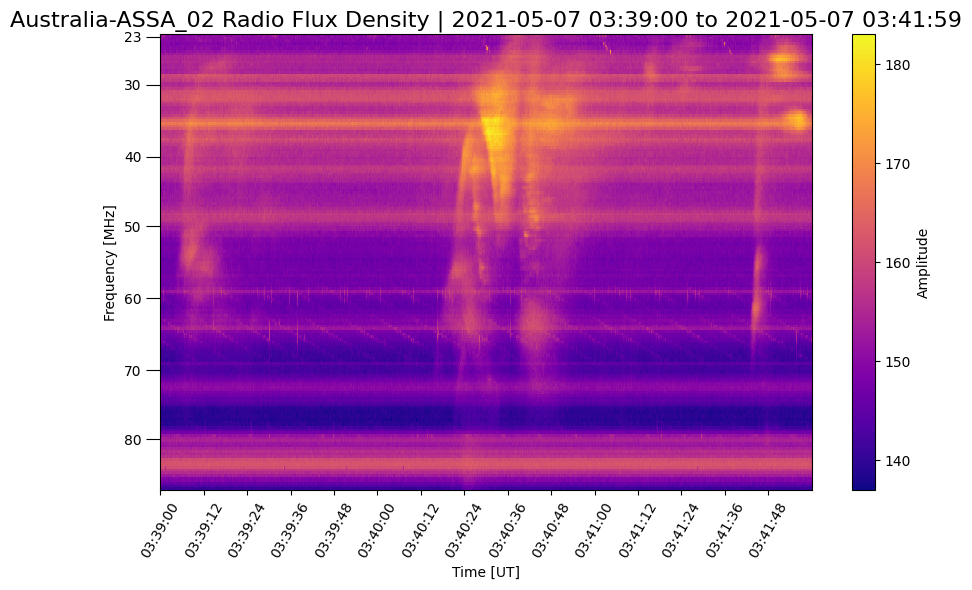

In [8]:
# Plot data
for data in datas:
    fig = plot_spectogram_mpl(data)

In [26]:
# Preprocess data
data_processed = preprocess_data(
    datas,
    db_space=True,
    min_n_frequencies=30,
    subtract_background=True,
    filter_type="median",
    freq_range=[20, 80],
)

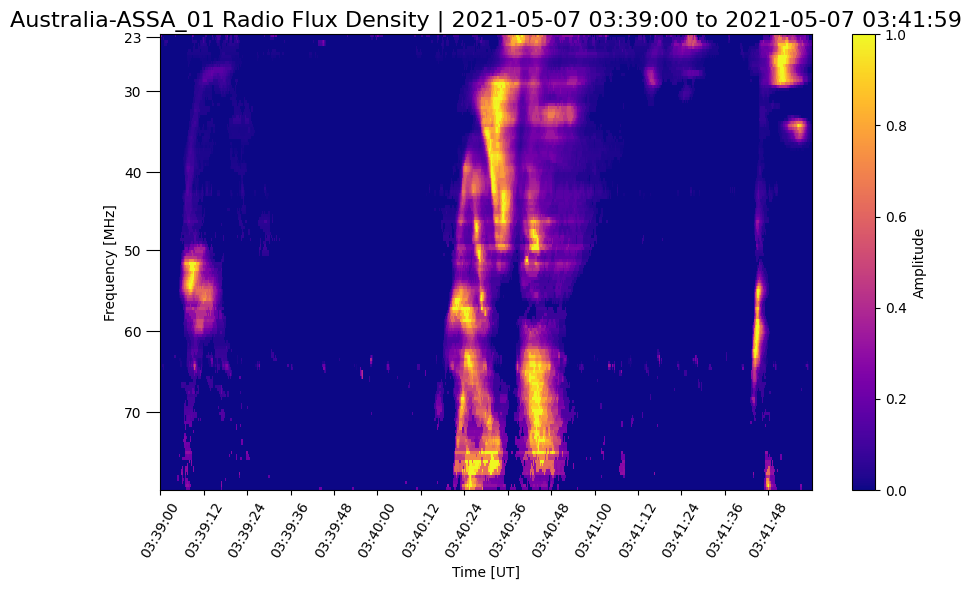

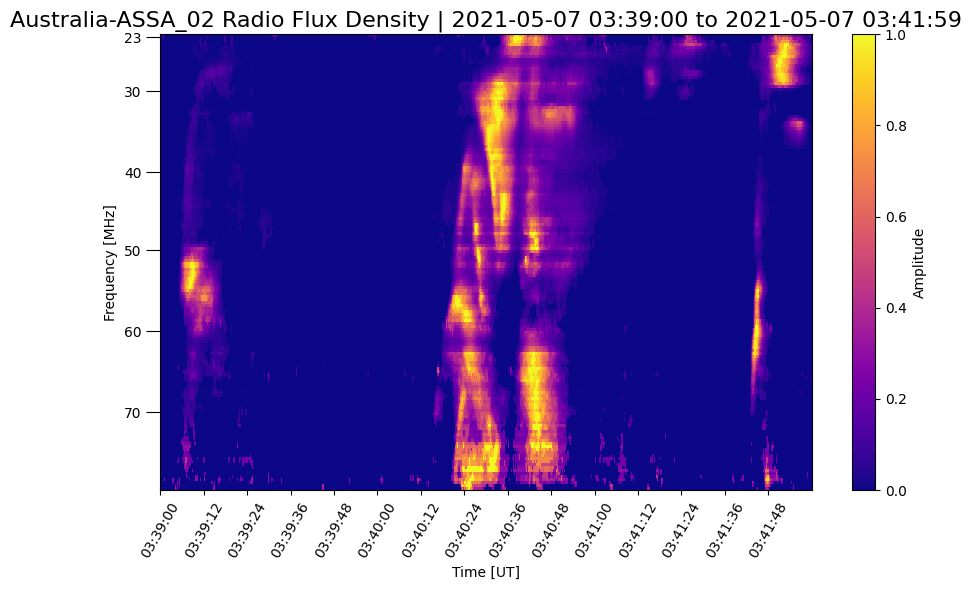

In [27]:
for data in data_processed:
    fig = plot_spectogram_mpl(data)

In [28]:
# Bin the frequencies. Not necessary but useful because the observed frequencies may vary a lot between the different antennas
data_binned = round_frequencies_to_nearest_bin(data_processed, 0.2, method="round")
# Gewichtete Intesntität der einzelnen Antennen in Bins. Rebinning machen!
# Linear bringt vielleicht falsche Informationen.

In [29]:
len(data_processed)

2

In [30]:
matched_data = match_spectrograms(data_binned)

In [31]:
synced_data, ref_idx = sync_spectrograms(matched_data)

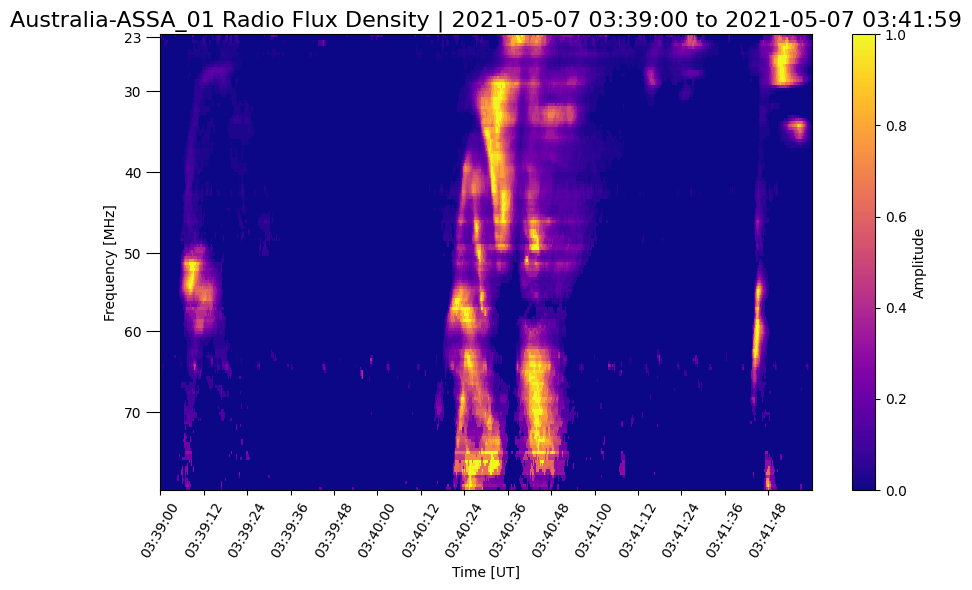

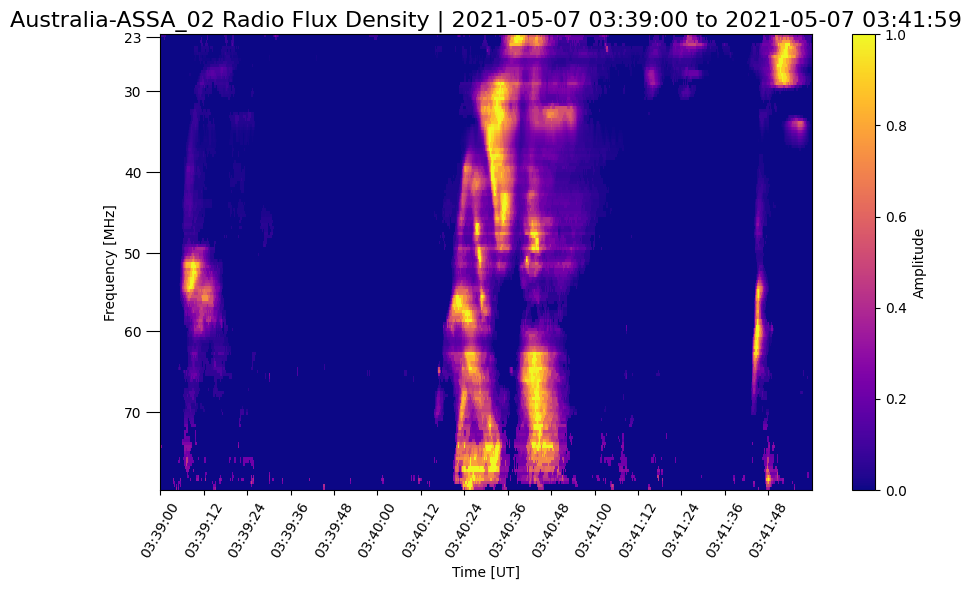

In [32]:
for data in synced_data:
    fig = plot_spectogram_mpl(data)

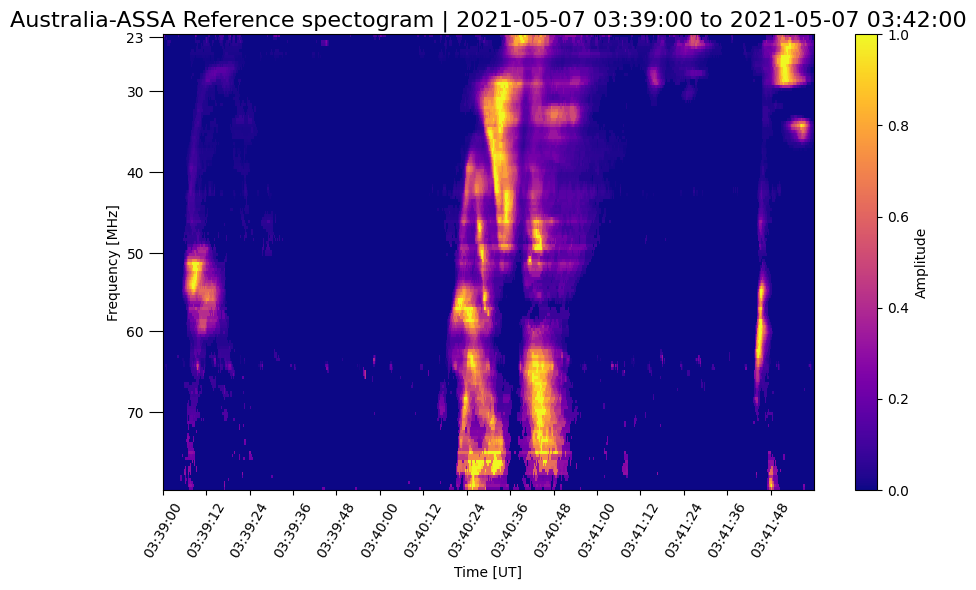

In [33]:
# Plot the spectogram, which most spectograms are in sync to
ref_spectogram_df = pd.DataFrame(
    synced_data[ref_idx], columns=synced_data[1].columns, index=synced_data[1].index
)
fig = plot_spectogram_mpl(
    synced_data[ref_idx],
    synced_data[ref_idx].attrs["INSTRUME"],
    start_datetime,
    end_datetime,
    title="Reference spectogram",
)

In [34]:
# Correlation with reference spectogram. Maybe we can do something with this?
def correlation_with_reference(spec_list, ref_idx):
    ref_spec = np.sum(spec_list[ref_idx], axis=1)
    correlations = []
    for spec in spec_list:
        correlations.append(np.corrcoef(ref_spec, np.sum(spec, axis=1))[0, 1])
    return correlations

In [35]:
corr_w_reference = correlation_with_reference(synced_data, ref_idx)
corr_w_reference

[1.0, 0.9991307591730119]

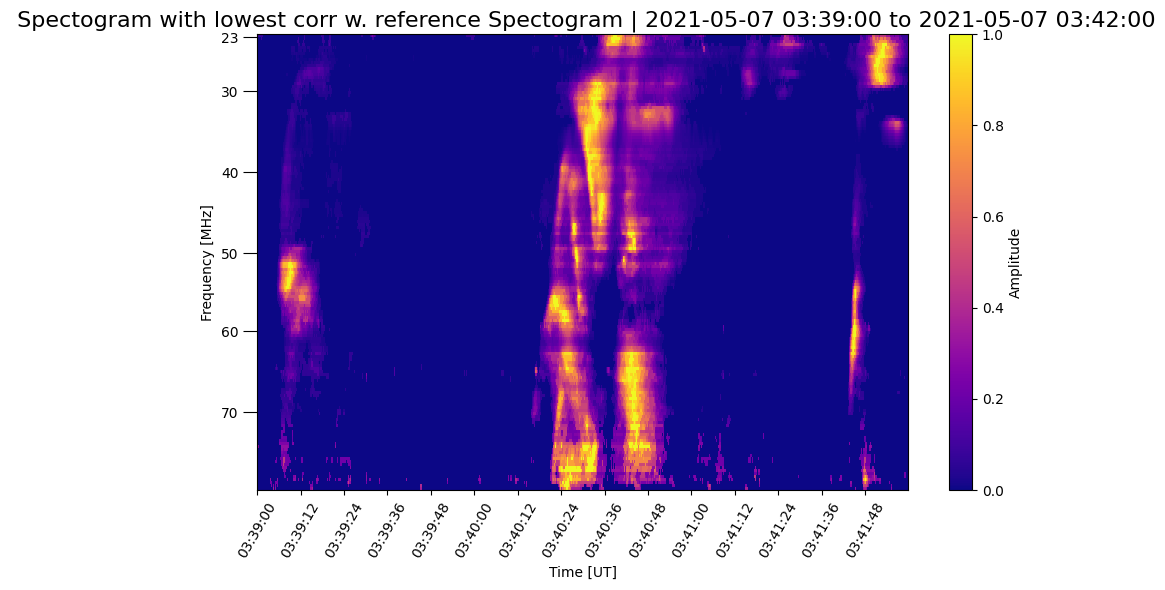

In [36]:
# Plot
fig = plot_spectogram_mpl(
    synced_data[np.argmin(corr_w_reference)],
    "",
    start_datetime,
    end_datetime,
    title="Spectogram with lowest corr w. reference Spectogram",
)

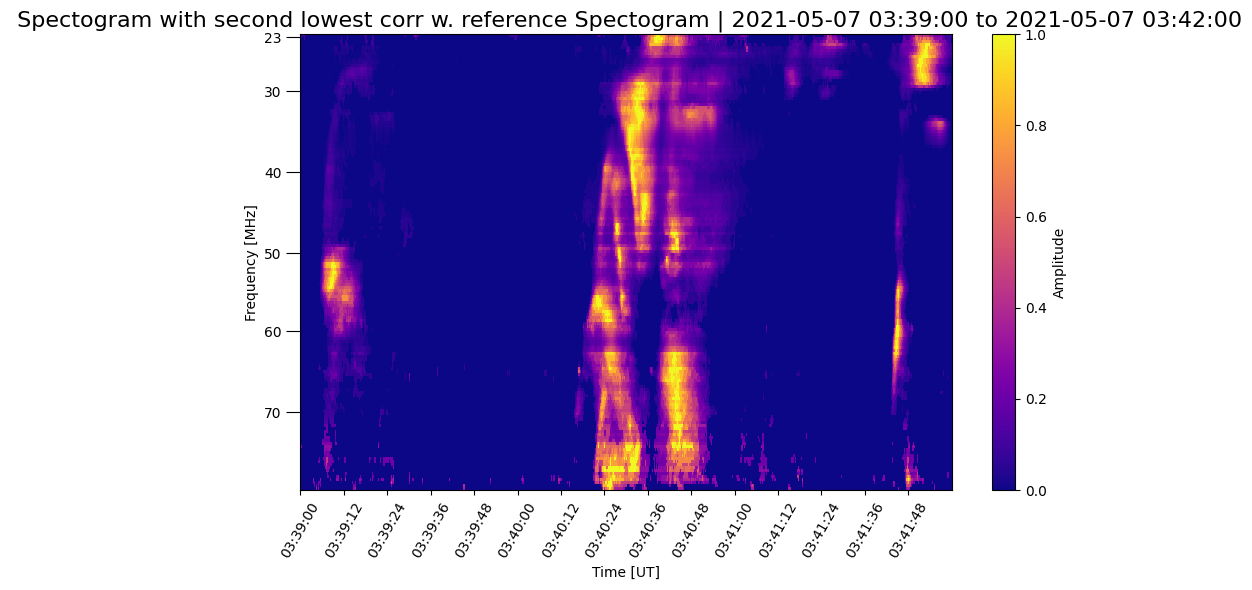

In [37]:
# Plot
fig = plot_spectogram_mpl(
    synced_data[-1],
    "",
    start_datetime,
    end_datetime,
    title="Spectogram with second lowest corr w. reference Spectogram",
)

In [38]:
# Calculate quantile of all matched and synced spectograms
QUANTILE = 0.6
##
torch_shifted = torch.stack([torch.from_numpy(df.values) for df in synced_data])
torch_quantile = torch.nanquantile(torch_shifted, QUANTILE, dim=0)

## Super slow version with numpy quantile
# np.nanquantile(np.stack([df.values for df in synced_data]), QUANTILE, axis=0)

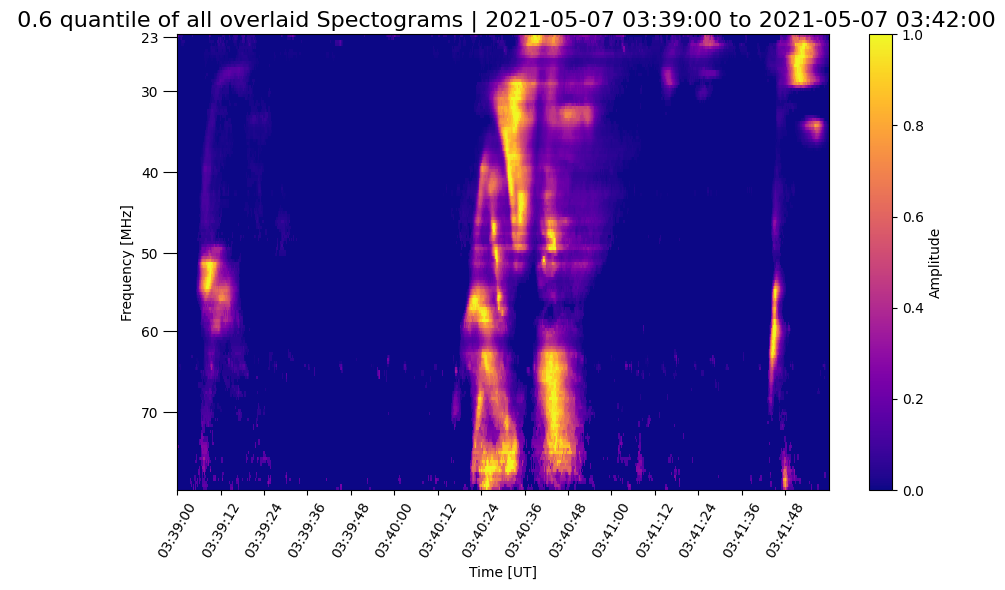

In [39]:
# Plot result
data_quantile_df = pd.DataFrame(
    torch_quantile, columns=synced_data[1].columns, index=synced_data[1].index
)
fig = plot_spectogram_mpl(
    data_quantile_df,
    "",
    start_datetime,
    end_datetime,
    title=f"{QUANTILE} quantile of all overlaid Spectograms",
)

In [40]:
# Filter out all spectograms with correlation below a certain threshold
CORR_THRESHOLD = 0.6
QUANTILE = 0.5

## Filter by corr
idx_to_keep = np.where(np.array(corr_w_reference) > CORR_THRESHOLD)[0]
synced_data_filtered = [synced_data[idx] for idx in idx_to_keep]
torch_corr = torch.stack([torch.from_numpy(df.values) for df in synced_data_filtered])

# Caculate quantile
torch_shifted = torch.stack([torch.from_numpy(df.values) for df in synced_data])
torch_quantile = torch.nanquantile(torch_shifted, QUANTILE, dim=0)

# Plot result
data_quantile_df = pd.DataFrame(
    torch_quantile, columns=synced_data[1].columns, index=synced_data[1].index
)
plot_spectogram(
    data_quantile_df,
    "",
    start_datetime,
    end_datetime,
    title=f"{QUANTILE} quantile of all overlaid and filtered Spectograms",
)

In [41]:
FROM = datetime(2021, 5, 7, 3, 40, 0)
TO = datetime(2021, 5, 7, 3, 41, 16)

In [43]:
data_quantile_df = pd.DataFrame(
    torch_quantile, columns=synced_data[1].columns, index=synced_data[1].index
)

data_quantile_df = data_quantile_df.loc[FROM:TO]
plot_spectogram(
    data_quantile_df,
    "",
    start_datetime,
    end_datetime,
    title=f"SOL2021-05-07T03:39, median of both ASSA antennas",
)